In [1]:
using DataFrames
using JLD
using PyPlot;
using ECOS;
using Convex;
set_default_solver(ECOSSolver(verbose=0))

ECOS.ECOSSolver(Any[(:verbose, 0)])

In [2]:
X = load("X1.jld")["X"] #DVOL, MMCNT, MCAP
Y = load("Y1.jld")["Y"] #PESP

notnans = .!isnan.(X[:,1]) .& .!isnan.(X[:,2]) .& .!isnan.(X[:,3]) .& .!isnan.(X[:,4]) .& .!isnan.(X[:,5]) .& .!isnan.(Y) .& .!isnan.(X[:,6])
Xc = X[notnans,:];
Yc = Y[notnans,:];

In [3]:
Xc\Yc

6×1 Array{Float64,2}:
  5.26028e-12
  3.29583e-11
  2.74664e-5 
  0.00832768 
 -5.11176e-5 
 -3.47981e-7 

In [4]:
# Add offset 
n = size(Xc)[1];
Xco = [ones(n) Xc];

In [5]:
Xco\Yc

7×1 Array{Float64,2}:
  0.0356337  
 -2.61955e-12
  1.12004e-11
  1.31455e-5 
 -0.0022505  
 -0.000695719
  1.0254e-7  

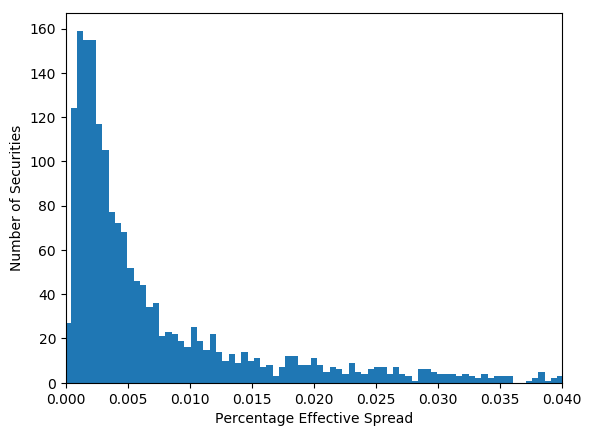

0.5815991237677984

In [6]:
PyPlot.plt[:hist](Yc,500)
PyPlot.plt[:xlim](0,.04)
PyPlot.plt[:xlabel]("Percentage Effective Spread");
PyPlot.plt[:ylabel]("Number of Securities"); 

sum(Yc.<=0.005)/size(Yc)[1]

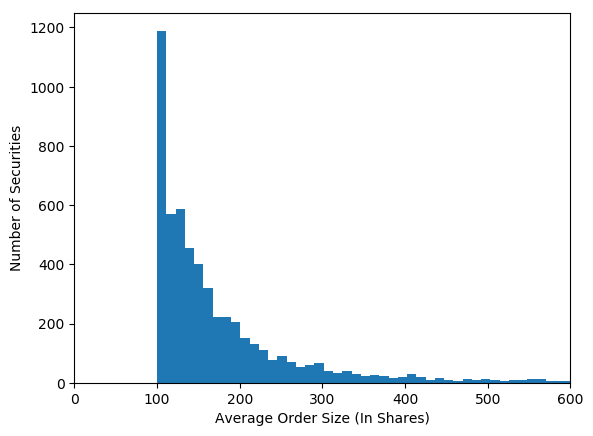

In [7]:
PyPlot.plt[:hist](X[:,3], 500)
PyPlot.plt[:xlim](0,600)
PyPlot.plt[:xlabel]("Average Order Size (In Shares)");
PyPlot.plt[:ylabel]("Number of Securities");

In [8]:
function winsorize(x,p1,p2)
    xw = zeros(size(x))
    xw .= x
    for i = 1:size(X)[2]
        low = quantile(x[:,i],p1,sorted = false)
        hi = quantile(x[:,i],p2,sorted = false)
        print(low)
        print(hi)
        temp = (x[:,i] .< low)
        xw[temp,i] = low
        temp = (x[:,i] .> hi)
        xw[temp,i] = hi
    end
    return xw
end

winsorize (generic function with 1 method)

In [9]:
Xcow = winsorize(Xco,.02,.98)
maximum(Xcow)

1.01.048502.7615955782243.079894907770408e815552.3069571428573.4140739961428575e7100.0548.55420806545890.020.991288239550537421.560.63333333333333

3.079894907770408e8

In [10]:
function standardize(X,y)
    X_standard = X .- mean(X,1)
    X_standard = X_standard * diagm(1./vec(std(X,1)))
    
    y_standard = y - mean(y)
    y_standard = y_standard / std(y)
    
    return X_standard, y_standard
end

standardize (generic function with 1 method)

In [11]:
Xcows, Ycs = standardize(Xcow, Yc);
Xcows[:,1] = 1
Xcows\Ycs

7×1 Array{Float64,2}:
  1.45337e-16
 -0.0105503  
  0.0336881  
  0.149712   
 -0.0453383  
 -0.556398   
  0.0403462  

In [12]:
#shuffle
#srand(78)
rand_ind = sortperm(rand(n));

Xcows_s = Xcows[rand_ind,:]
Ycs_s = Ycs[rand_ind,:]

Xtest = Xcows_s[1:Int(floor(.2*n)),:]
Xtrain = Xcows_s[Int(ceil(.2*n)):n,:]

Ytest = Ycs_s[1:Int(floor(.2*n)),:]
Ytrain = Ycs_s[Int(ceil(.2*n)):n,:]

ntrain = size(Xtrain)[1]
ntest = size(Xtest)[1]

365

In [24]:
w = Xtrain\Ytrain

7×1 Array{Float64,2}:
  0.000180009
 -0.0383022  
  0.0564476  
  0.158772   
 -0.0394251  
 -0.556392   
  0.0407796  

In [55]:
(sum(((Xtrain*w - Ytrain)*std(Yc)).^2)/ntrain)^.5

0.009772091426068228

In [50]:
sum((Xtest*w - Ytest).^2)/ntest

1.1537627399298742

In [57]:
(sum(((Xtest*w - Ytest)*std(Yc)).^2)/ntest)^.5

0.013881280071617437

In [56]:
sum((Xtrain*w - Ytrain).^2)/ntrain

0.5717846854543164

In [58]:
mean(Yc)

0.008611479969619806

In [16]:

function ridge_regression(X,y; λ=1)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y) + λ*sumsquares(w))
    solve!(p)
    return w.value
end

ridge_regression (generic function with 1 method)

In [17]:
w_ridge = ridge_regression(Xtrain,Ytrain; λ=1)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Convex.ConicConstr}, ::Int64) at ./deprecated.jl:57
 [3] conic_form!(::Convex.SOCElemConstraint, ::Convex.UniqueConicForms) at /Users/greg/.julia/v0.6/Convex/src/constraints/soc_constraints.jl:50
 [4] conic_form!(::Convex.QolElemAtom, ::Convex.UniqueConicForms) at /Users/greg/.julia/v0.6/Convex/src/atoms/second_order_cone/qol_elementwise.jl:41
 [5] conic_form!(::Convex.AdditionAtom, ::Convex.UniqueConicForms) at /Users/greg/.julia/v0.6/Convex/src/atoms/affine/add_subtract.jl:108
 [6] conic_form!(::Convex.EqConstraint, ::Convex.UniqueConicForms) at /Users/greg/.julia/v0.6/Convex/src/constraints/constraints.jl:43
 [7] conic_form!(::Convex.Problem, ::Convex.UniqueConicForms) at /Users/greg/.julia/v0.6/Convex/src/problems.jl:99
 [8] conic_problem(::Convex.Problem) at /Users/greg/.julia/v0.6/Convex/src/problems.jl:124
 [9] #solve!#25(::Bool, ::Bool, ::Bool, ::Function, ::Convex.Problem) at /Users/greg/.juli

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] isnan(::Array{Float64,1}) at ./deprecated.jl:57
 [3] populate_solution!(::ECOS.ECOSMathProgModel, ::Convex.Problem, ::Dict{UInt64,Tuple{Int64,Int64}}, ::Array{Convex.ConicConstr,1}) at /Users/greg/.julia/v0.6/Convex/src/solution.jl:118
 [4] #solve!#25(::Bool, ::Bool, ::Bool, ::Function, ::Convex.Problem) at /Users/greg/.julia/v0.6/Convex/src/solution.jl:38
 [5] #ridge_regression#11(::Int64, ::Function, ::Array{Float64,2}, ::Array{Float64,2}) at ./In[16]:6
 [6] (::#kw##ridge_regression)(::Array{Any,1}, ::#ridge_regression, ::Array{Float64,2}, ::Array{Float64,2}) at ./<missing>:0
 [7] include_string(::String, ::String) at ./loading.jl:515
 [8] include_string(::Module, ::String, ::String) at /Users/greg/.julia/v0.6/Compat/src/Compat.jl:464
 [9] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/greg/.julia/v0.6/IJulia/src/execute_request.jl:154
 [10] eventloop(::ZMQ.Socket) at /Users/greg/.julia/v0.6/IJulia/src/eve

7×1 Array{Float64,2}:
  0.000191442
 -0.0378854  
  0.0559097  
  0.158688   
 -0.039441   
 -0.555846   
  0.0405528  

In [18]:
function lasso(X,y; λ=1)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y) + λ*norm(w,1))
    solve!(p)
    return w.value
end

lasso (generic function with 1 method)

In [19]:
w_lasso = lasso(Xtrain,Ytrain, λ=1)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Convex.ConicConstr}, ::Int64) at ./deprecated.jl:57
 [3] conic_form!(::Convex.SOCElemConstraint, ::Convex.UniqueConicForms) at /Users/greg/.julia/v0.6/Convex/src/constraints/soc_constraints.jl:50
 [4] conic_form!(::Convex.QolElemAtom, ::Convex.UniqueConicForms) at /Users/greg/.julia/v0.6/Convex/src/atoms/second_order_cone/qol_elementwise.jl:41
 [5] conic_form!(::Convex.AdditionAtom, ::Convex.UniqueConicForms) at /Users/greg/.julia/v0.6/Convex/src/atoms/affine/add_subtract.jl:108
 [6] conic_form!(::Convex.EqConstraint, ::Convex.UniqueConicForms) at /Users/greg/.julia/v0.6/Convex/src/constraints/constraints.jl:43
 [7] conic_form!(::Convex.Problem, ::Convex.UniqueConicForms) at /Users/greg/.julia/v0.6/Convex/src/problems.jl:99
 [8] conic_problem(::Convex.Problem) at /Users/greg/.julia/v0.6/Convex/src/problems.jl:124
 [9] #solve!#25(::Bool, ::Bool, ::Bool, ::Function, ::Convex.Problem) at /Users/greg/.juli

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] isnan(::Array{Float64,1}) at ./deprecated.jl:57
 [3] populate_solution!(::ECOS.ECOSMathProgModel, ::Convex.Problem, ::Dict{UInt64,Tuple{Int64,Int64}}, ::Array{Convex.ConicConstr,1}) at /Users/greg/.julia/v0.6/Convex/src/solution.jl:118
 [4] #solve!#25(::Bool, ::Bool, ::Bool, ::Function, ::Convex.Problem) at /Users/greg/.julia/v0.6/Convex/src/solution.jl:38
 [5] #lasso#12(::Int64, ::Function, ::Array{Float64,2}, ::Array{Float64,2}) at ./In[18]:5
 [6] (::#kw##lasso)(::Array{Any,1}, ::#lasso, ::Array{Float64,2}, ::Array{Float64,2}) at ./<missing>:0
 [7] include_string(::String, ::String) at ./loading.jl:515
 [8] include_string(::Module, ::String, ::String) at /Users/greg/.julia/v0.6/Compat/src/Compat.jl:464
 [9] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/greg/.julia/v0.6/IJulia/src/execute_request.jl:154
 [10] eventloop(::ZMQ.Socket) at /Users/greg/.julia/v0.6/IJulia/src/eventloop.jl:8
 [11] (::IJulia.##14#

7×1 Array{Float64,2}:
 -1.96198e-11
 -0.0326744  
  0.0518441  
  0.158217   
 -0.0389243  
 -0.555946   
  0.0390856  